In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import pandas as pd
import calendar
import plotly.graph_objects as go
import itertools
import math
import networkx as nx
from community import community_louvain
import EoN
import sklearn 
import sklearn.cluster
from matplotlib.pyplot import axhline
from matplotlib.pyplot import subplots
import seaborn as sns
from sympy import Symbol, Derivative, solve, Eq, lambdify


# SIR model

In [2]:
def plotdata_ex(t, s, e, i, r, a):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, s, lw=3, label='Fraction Susceptible')
    ax[0].plot(t, i, lw=3, label='Fraction Infective')
    ax[0].plot(t, r, lw=3, label='Recovered')
    ax[0].plot(t, a, lw=3, label='Asymptomatic')
    ax[0].set_title('Susceptible and Recovered Populations')
    #ax[0].set_xlabel('Time /days')
    #hide x label
    ax[0].set_xticklabels([])
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective', color="#ff7f0e")
    ax[1].set_title('Infectious Population')
    if e is not None: ax[1].plot(t, e, lw=3, label='Exposed', color= "#9467bd")
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(s, i, lw=3, label='s, i trajectory')
    ax[2].plot([0.1, 0.1], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()
    plt.savefig('./Images/SEAIR.png', bbox_inches='tight')
    plt.tight_layout()
    


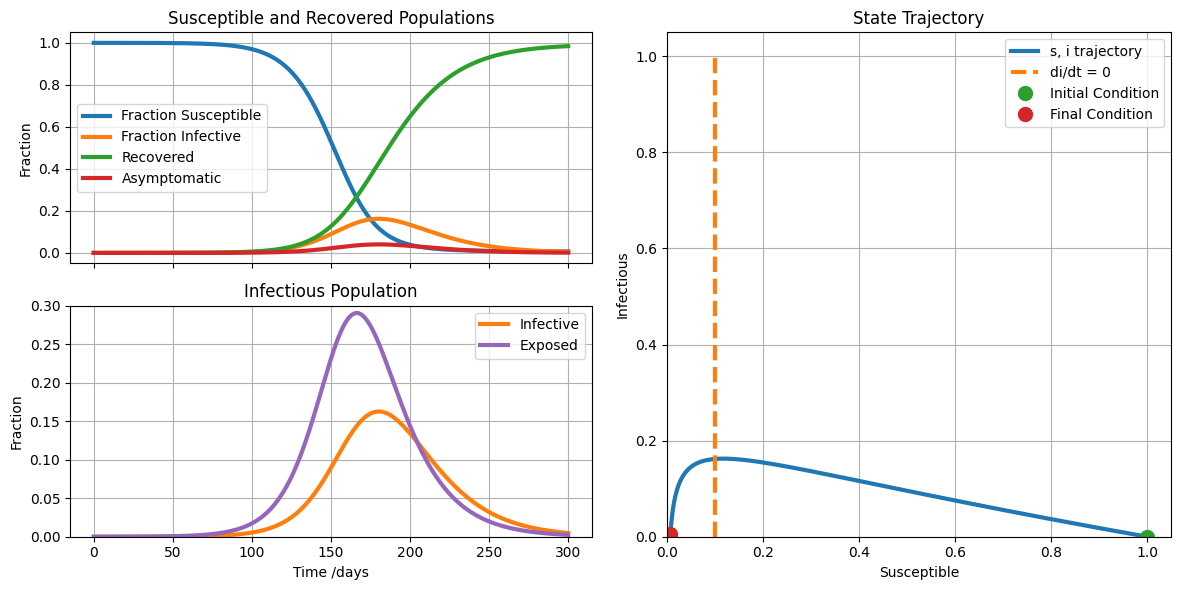

In [3]:
# parameter values
R0 = 5
t_incubation = 21
t_infective = 1/0.05882
#Proportion of those asymptomatic	
p = 0.2
u = 0

# initial number of infected and recovered individuals
e_initial = 1/20000
i_initial = 0.00
r_initial = 0.00
a_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial -a_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma, p):
    s, e, i, r ,a = x
    dsdt = -(1-u)*beta * s * (i+a)
    dedt =  (1-u)*beta * s * (i+a) - alpha * e
    dadt = alpha * e *p - gamma * a
    didt = alpha * e *(1-p) - gamma * i
    drdt =  gamma * i+ gamma * a
    return [dsdt, dedt, didt, drdt, dadt]

t = np.linspace(0, 300, 2000)
x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T

plotdata_ex(t, s, e, i, r, a)

### Analyse de sensibilité du modèle
Notre but est de voir quel paramètre aura la plus grande influence sur le nombre de personne infectées. Et donc, sur quel paramêtre la marge d'erreur autorisé sera la plus faible.

In [4]:

def get_info_infected(t, i):
    max_index = np.argmax(i) #max_index = position of max value of i in array
    max_value = max(i) #max_value = value of max value of i in array
    time_max_i = t[max_index] #time_max_i = time at which max value of i is reached
    
    #print("max value of i is", max_value, "at time", time_max_i)
    
    return max_value, time_max_i

Les trois paramètres à faire varier sont : alpha (transition de E à I ou A), beta (transition de S à E), gamma (transition de A et I à R).
Leurs valeurs sont fixées à :    
* alpha = 0.048    
* beta = 0.2941  
* gamma = 0.05882  

In [5]:
# parameter values
R0 = 5
t_incubation = 21
t_infective = 1/0.05882
#Proportion of those asymptomatic	
p = 0.2
u = 0

# initial number of infected and recovered individuals
e_initial = 1/20000
i_initial = 0.00
r_initial = 0.00
a_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial -a_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma




list_variation = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
number_of_people = 40000

# sensibility analysis of alpha
dict_alpha = {}
for i in range (2):
    if i == 0:
        for j in list_variation:
            alpha = 1/t_incubation * j
            gamma = 1/t_infective 
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            max_value, time_max_i = get_info_infected(t, i)
            dict_alpha[-(1-j)] = max_value*number_of_people, time_max_i
            
        alpha = 1/t_incubation 
        gamma = 1/t_infective 
        beta = R0*gamma 
        x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
        soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
        s, e, i, r, a = soln.T
        
        max_value, time_max_i = get_info_infected(t, i)
        dict_alpha[0] = max_value*number_of_people, time_max_i

    else:
        for j in list_variation:
            alpha = 1/t_incubation * j + 1/t_incubation
            gamma = 1/t_infective 
            beta = R0*gamma 
            
            t = np.linspace(0, 2000, 4000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            max_value, time_max_i = get_info_infected(t, i)
            dict_alpha[j] = max_value*number_of_people, time_max_i
    
# sensibility analysis of beta
dict_beta = {}
for i in range (2):
    if i == 0:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective 
            beta = R0*gamma * j
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            max_value, time_max_i = get_info_infected(t, i)
            dict_beta[-(1-j)] = max_value*number_of_people, time_max_i
        
        alpha = 1/t_incubation 
        gamma = 1/t_infective 
        beta = R0*gamma 
        x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
        soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
        s, e, i, r, a = soln.T
        
        max_value, time_max_i = get_info_infected(t, i)
        dict_beta[0] = max_value*number_of_people, time_max_i
        
    else:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective 
            beta = R0*gamma * j + R0*gamma
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            max_value, time_max_i = get_info_infected(t, i)
            dict_beta[j] = max_value*number_of_people, time_max_i

# sensibility analysis of gamma
dict_gamma = {}
for i in range (2):
    if i == 0:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective * j
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            max_value, time_max_i = get_info_infected(t, i)
            dict_gamma[-(1-j)] = max_value*number_of_people, time_max_i
            
        alpha = 1/t_incubation 
        gamma = 1/t_infective 
        beta = R0*gamma 
        x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
        soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
        s, e, i, r, a = soln.T
        
        max_value, time_max_i = get_info_infected(t, i)
        dict_gamma[0] = max_value*number_of_people, time_max_i

    else:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective * j + 1/t_infective
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            max_value, time_max_i = get_info_infected(t, i)
            dict_gamma[j] = max_value*number_of_people, time_max_i


In [6]:
dict_alpha_list = {}
dict_beta_list = {}
dict_gamma_list = {}
for i in range (2):
    if i == 0:
        for j in list_variation:
            alpha = 1/t_incubation *j
            gamma = 1/t_infective 
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            i = list(i)
            
            dict_alpha_list[round(-(1-j),2)] = i

        
        alpha = 1/t_incubation 
        gamma = 1/t_infective 
        beta = R0*gamma 
        x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
        soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
        s, e, i, r, a = soln.T
        
        i = list(i)
        dict_alpha_list[0] = i
        
    else:
        for j in list_variation:
            alpha = 1/t_incubation *j + 1/t_incubation
            gamma = 1/t_infective 
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            i = list(i)
            dict_alpha_list[j] = i
        

for i in range (2):
    if i == 0:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective
            beta = R0*gamma *j
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            i = list(i)
            
            dict_beta_list[round(-(1-j),2)] = i

        
        alpha = 1/t_incubation 
        gamma = 1/t_infective 
        beta = R0*gamma 
        x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
        soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
        s, e, i, r, a = soln.T
        
        i = list(i)
        dict_beta_list[0] = i
        
    else:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective 
            beta = R0*gamma *j + R0*gamma
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            i = list(i)
            dict_beta_list[j] = i



for i in range (2):
    if i == 0:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective *j
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            i = list(i)
            
            dict_gamma_list[round(-(1-j),2)] = i

        
        alpha = 1/t_incubation 
        gamma = 1/t_infective 
        beta = R0*gamma 
        x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
        soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
        s, e, i, r, a = soln.T
        
        i = list(i)
        dict_gamma_list[0] = i
        
    else:
        for j in list_variation:
            alpha = 1/t_incubation 
            gamma = 1/t_infective *j + 1/t_infective
            beta = R0*gamma 
            
            t = np.linspace(0, 1000, 2000)
            x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
            soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
            s, e, i, r, a = soln.T
            
            i = list(i)
            dict_gamma_list[j] = i      

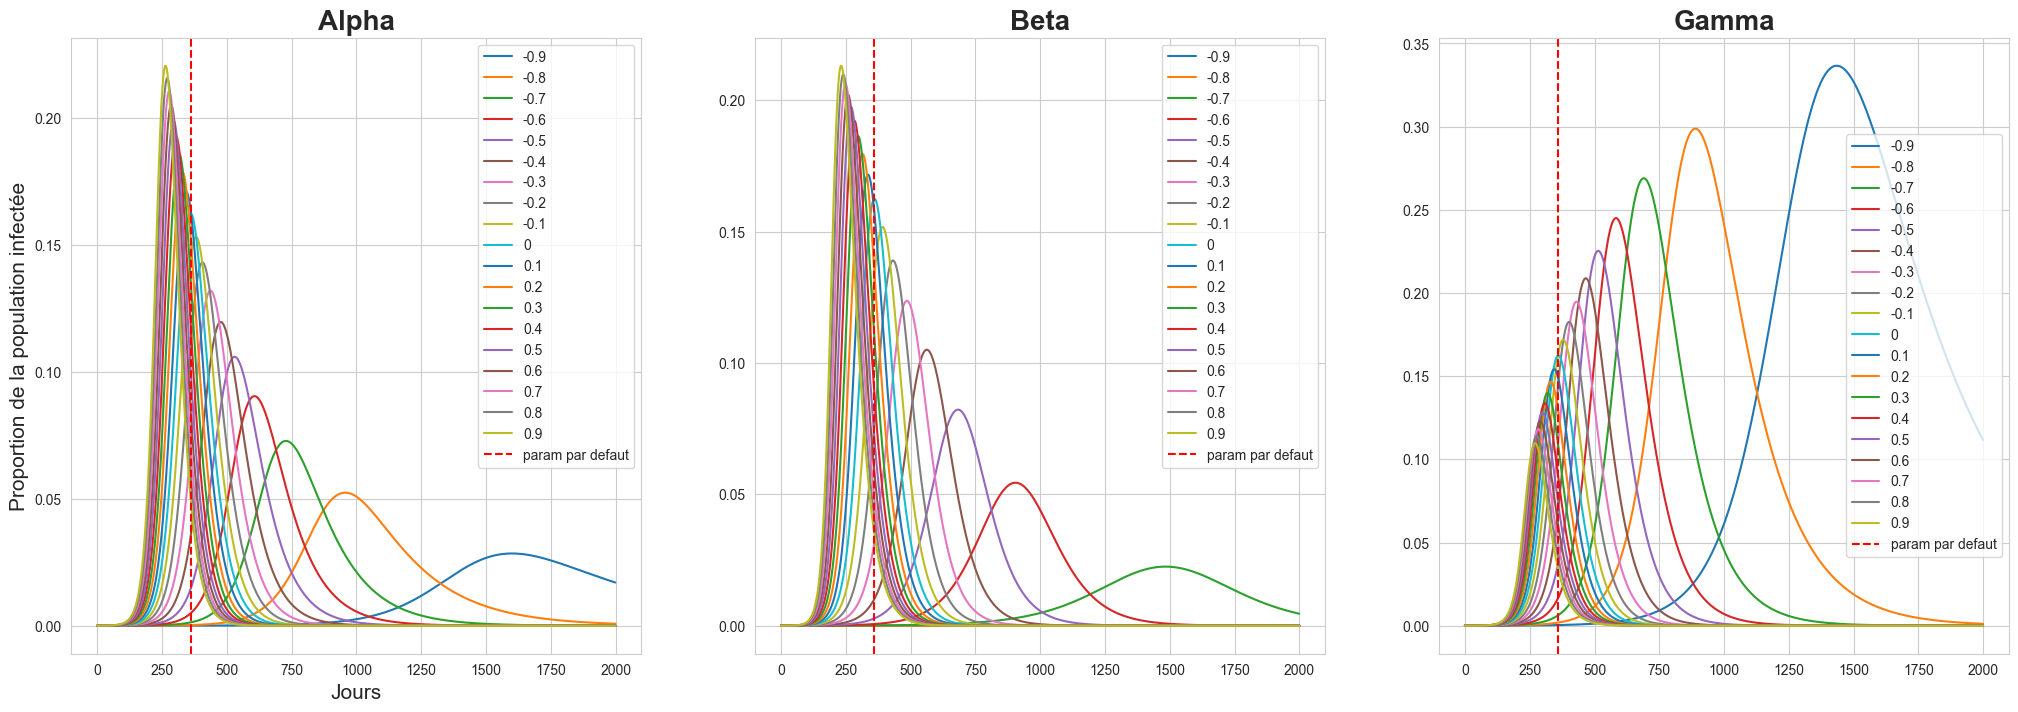

In [21]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
    # plot each curve
for label, values in dict_alpha_list.items():
    ax1.plot(values, label=label)
ax1.set_title('Alpha', fontsize=20, fontweight='bold')
#draw a vertical line at x = 360 
ax1.axvline(x=360, color='r', linestyle='--', label ="param par defaut")
ax1.legend()
#set x and y labels
ax1.set_xlabel('Jours', fontsize=15)
ax1.set_ylabel('Proportion de la population infectée', fontsize=15)


for label, values in dict_beta_list.items():
    ax2.plot(values, label=label)
ax2.axvline(x=360, color='r', linestyle='--', label ="param par defaut")
ax2.legend()
ax2.set_title('Beta', fontsize=20, fontweight='bold')

for label, values in dict_gamma_list.items():
    ax3.plot(values, label=label)
ax3.axvline(x=360, color='r', linestyle='--', label ="param par defaut")
ax3.legend()
ax3.set_title('Gamma', fontsize=20, fontweight='bold')
plt.savefig('./Images/param_test.png')
plt.show()




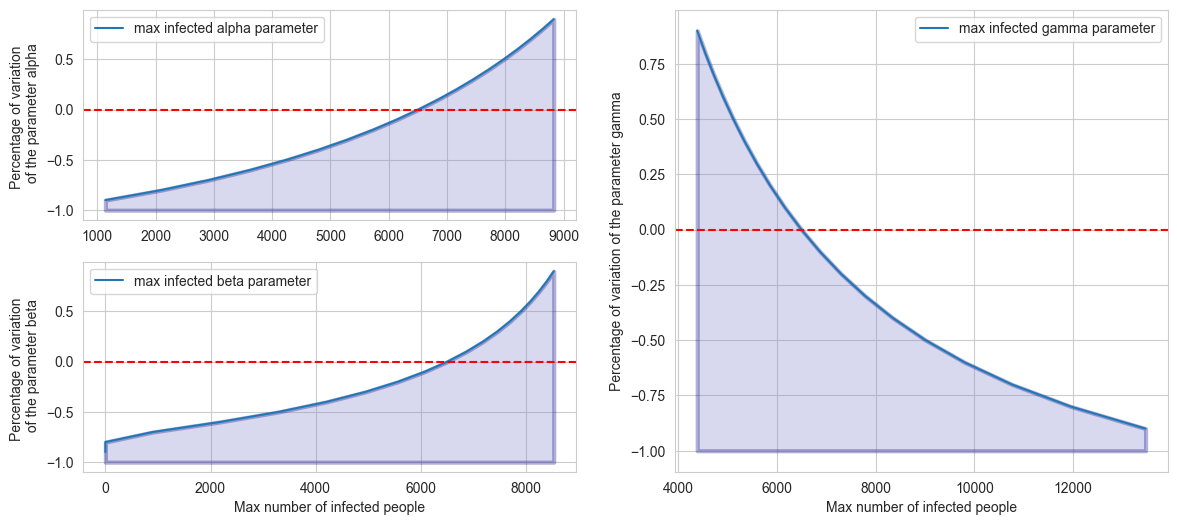

In [8]:
sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)

fig = plt.figure(figsize=(14,6))
ax = [fig.add_subplot(221, axisbelow=True), 
        fig.add_subplot(223),
        fig.add_subplot(122)]

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]


# Tracé du premier graphique sur la première ligne du sous-tracé
ax1.plot([i[0] for i in list(dict_alpha.values())], list(dict_alpha.keys()), label='max infected alpha parameter')
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_ylabel('Percentage of variation \n of the parameter alpha')
#ax1.set_xlabel('Max number of infected people')
ax1.legend()
ax1.grid('on')
l = ax1.fill_between(x= [i[0] for i in list(dict_alpha.values())], y1= -1, y2= list(dict_alpha.keys()))
l.set_edgecolors([[0, 0, .5, .3]])
l.set_linewidths([3])
l.set_facecolors([[.5,.5,.8,.3]])
ax1.spines['right'].set_color((.8,.8,.8))
ax1.spines['top'].set_color((.8,.8,.8))

# Tracé du deuxième graphique sur la deuxième ligne du sous-tracé
ax2.plot([i[0] for i in list(dict_beta.values())], list(dict_beta.keys()), label='max infected beta parameter')
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_ylabel('Percentage of variation \n of the parameter beta')
ax2.set_xlabel('Max number of infected people')
ax2.legend()
ax2.grid('on')
l = ax2.fill_between(x= [i[0] for i in list(dict_beta.values())], y1= -1, y2= list(dict_beta.keys()))
l.set_edgecolors([[0, 0, .5, .3]])
l.set_linewidths([3])
l.set_facecolors([[.5,.5,.8,.3]])

# Tracé du troisième graphique sur la troisième ligne du sous-tracé
ax3.plot([i[0] for i in list(dict_gamma.values())], list(dict_gamma.keys()), label='max infected gamma parameter')
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_ylabel('Percentage of variation of the parameter gamma')
ax3.set_xlabel('Max number of infected people')
ax3.legend()
ax3.grid('on')
l = ax3.fill_between(x= [i[0] for i in list(dict_gamma.values())], y1= -1, y2= list(dict_gamma.keys()))
l.set_edgecolors([[0, 0, .5, .3]])
l.set_linewidths([3])
l.set_facecolors([[.5,.5,.8,.3]])

# Afficher le sous-tracé
plt.savefig('./Images/sensibility_analysis.png')

plt.show()

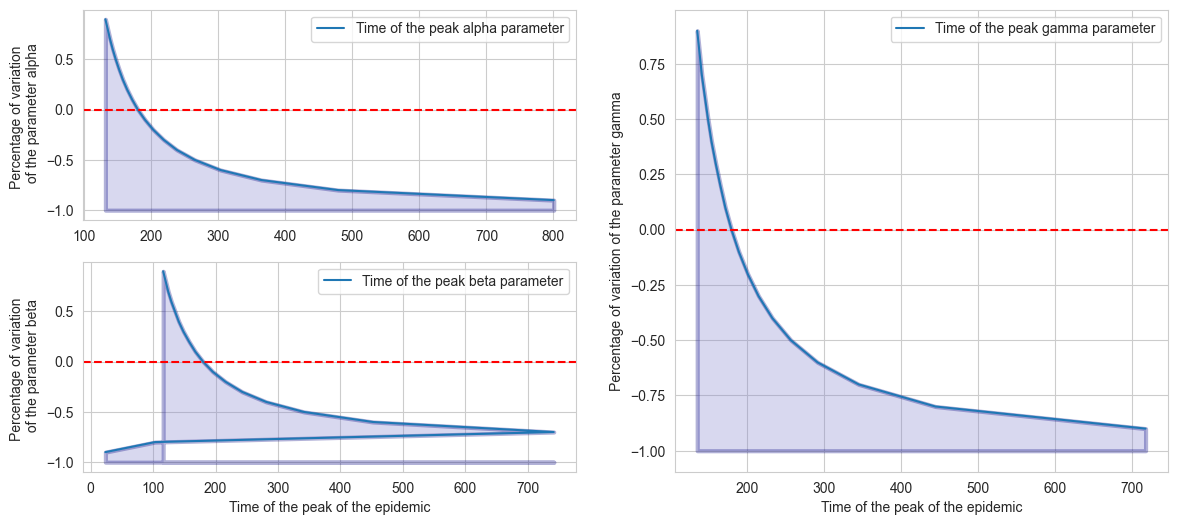

In [9]:
sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)

fig = plt.figure(figsize=(14,6))
ax = [fig.add_subplot(221, axisbelow=True), 
        fig.add_subplot(223),
        fig.add_subplot(122)]

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]


# Tracé du premier graphique sur la première ligne du sous-tracé
ax1.plot([i[1] for i in list(dict_alpha.values())], list(dict_alpha.keys()), label='Time of the peak alpha parameter')
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_ylabel('Percentage of variation \n of the parameter alpha')
#ax1.set_xlabel('Max number of infected people')
ax1.legend()
ax1.grid('on')
l = ax1.fill_between(x= [i[1] for i in list(dict_alpha.values())], y1= -1, y2= list(dict_alpha.keys()))
l.set_edgecolors([[0, 0, .5, .3]])
l.set_linewidths([3])
l.set_facecolors([[.5,.5,.8,.3]])
ax1.spines['right'].set_color((.8,.8,.8))
ax1.spines['top'].set_color((.8,.8,.8))

# Tracé du deuxième graphique sur la deuxième ligne du sous-tracé
ax2.plot([i[1] for i in list(dict_beta.values())], list(dict_beta.keys()), label='Time of the peak beta parameter')
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_ylabel('Percentage of variation \n of the parameter beta')
ax2.set_xlabel('Time of the peak of the epidemic')
ax2.legend()
ax2.grid('on')
l = ax2.fill_between(x= [i[1] for i in list(dict_beta.values())], y1= -1, y2= list(dict_beta.keys()))
l.set_edgecolors([[0, 0, .5, .3]])
l.set_linewidths([3])
l.set_facecolors([[.5,.5,.8,.3]])

# Tracé du troisième graphique sur la troisième ligne du sous-tracé
ax3.plot([i[1] for i in list(dict_gamma.values())], list(dict_gamma.keys()), label='Time of the peak gamma parameter')
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_ylabel('Percentage of variation of the parameter gamma')
ax3.set_xlabel('Time of the peak of the epidemic')
ax3.legend()
ax3.grid('on')
l = ax3.fill_between(x= [i[1] for i in list(dict_gamma.values())], y1= -1, y2= list(dict_gamma.keys()))
l.set_edgecolors([[0, 0, .5, .3]])
l.set_linewidths([3])
l.set_facecolors([[.5,.5,.8,.3]])

# Afficher le sous-tracé
plt.savefig('./Images/sensibility_analysis_time.png')

plt.show()

### Get the slopes of all the curves.

#### For infected people

In [10]:
x = [i[0] for i in list(dict_gamma.values())]
y = list(dict_alpha.keys())

def find_slope(x, param_slope, y= list(dict_alpha.keys()) ):
    #param slope for alpha = 1, for beta = 1, for gamma = 0
    a, b, c = np.polyfit(x, y, 2)
    x = Symbol('x')
    y = a*x**2 + b*x + c

    # Find the derivative of the curve
    deriv = lambdify(x, y)
    #give the root of the curve
    root = solve(y)
    root1 = root[param_slope]
    y = 2*a*root1 +b
    
    return y


print("The slope of alpha is : {}".format(find_slope([i[0] for i in list(dict_alpha.values())], 0)))
print("The slope of beta is : {}".format(find_slope([i[0] for i in list(dict_beta.values())], 0)))
print("The slope of gamma is : {}".format(find_slope([i[0] for i in list(dict_gamma.values())], 0)))

The slope of alpha is : -0.000295659440882699
The slope of beta is : -0.000273881370545740
The slope of gamma is : -0.000292105783094566


In [11]:
x = [i[0] for i in list(dict_alpha.values())]
y = list(dict_alpha.keys())
a, b, c = np.polyfit(x, y, 2)
x = Symbol('x')
y_alpha = a*x**2 + b*x + c

x = [i[0] for i in list(dict_beta.values())]
a, b, c = np.polyfit(x, y, 2)
x = Symbol('x')
y_beta = a*x**2 + b*x + c

x = [i[0] for i in list(dict_gamma.values())]
a, b, c = np.polyfit(x, y, 2)
x = Symbol('x')
y_gamme = a*x**2 + b*x + c


print("The equuation of alpha is : {}".format(y_alpha))
print("The equuation of beta is : {}".format(y_beta))
print("The equuation of gamma is : {}".format(y_gamme))


The equuation of alpha is : 2.52704727740031e-8*x**2 - 2.9440380680305e-5*x - 0.856214382517451
The equuation of beta is : 2.40825475278026e-8*x**2 - 2.60077992613591e-5*x - 0.771664619614851
The equuation of gamma is : 2.52996569672345e-8*x**2 - 0.000630291742987612*x + 3.08247156438788


#### For time

In [12]:
print("The slope of alpha is : {}".format(find_slope([i[1] for i in list(dict_alpha.values())], 0)))
print("The slope of beta is : {}".format(find_slope([i[1] for i in list(dict_beta.values())], 1)))
print("The slope of gamma is : {}".format(find_slope([i[1] for i in list(dict_gamma.values())], 0)))

The slope of alpha is : -0.00685383172117212
The slope of beta is : -0.00145302665709428
The slope of gamma is : -0.00771302380456221


In [13]:
x = [i[1] for i in list(dict_alpha.values())]
y = list(dict_alpha.keys())
a, b, c = np.polyfit(x, y, 2)
x = Symbol('x')
y_alpha = a*x**2 + b*x + c

x = [i[1] for i in list(dict_beta.values())]
a, b, c = np.polyfit(x, y, 2)
x = Symbol('x')
y_beta = a*x**2 + b*x + c

x = [i[1] for i in list(dict_gamma.values())]
a, b, c = np.polyfit(x, y, 2)
x = Symbol('x')
y_gamme = a*x**2 + b*x + c


print("The equuation of alpha is : {}".format(y_alpha))
print("The equuation of beta is : {}".format(y_beta))
print("The equuation of gamma is : {}".format(y_gamme))


The equuation of alpha is : 9.26444432033068e-6*x**2 - 0.0106642902995722*x + 1.80129741254201
The equuation of beta is : -4.09829433007801e-7*x**2 - 0.00127410226447832*x + 0.297654247461346
The equuation of gamma is : 1.19730973439138e-5*x**2 - 0.0125584327207485*x + 2.05092077201211


# Wuhan model (with asymptomatic)

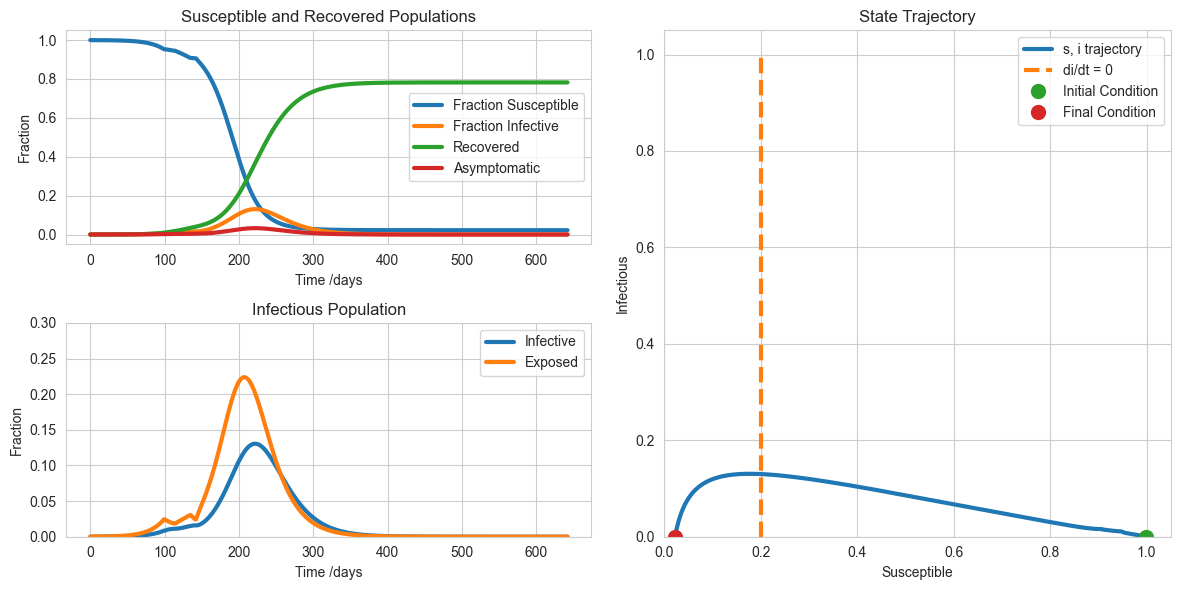

In [14]:
def plotdata(t, list_s, list_i, list_e, list_r):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, list_s, lw=3, label='Fraction Susceptible')
    ax[0].plot(t, list_i, lw=3, label='Fraction Infective')
    ax[0].plot(t, list_r, lw=3, label='Recovered')
    ax[0].plot(t, list_a, lw=3, label='Asymptomatic')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, list_i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if list_e is not None: ax[1].plot(t, list_e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(list_s, list_i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(list_s[0], list_i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(list_s[-1], list_i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()


list_e = []
list_i = []
list_r = []
list_s = []
list_a = []
# parameter values

R0 = 5
t_incubation = 21
#Proportion of those asymptomatic	
p = 0.2

# initial number of infected and recovered individuals
e_initial = 10/40000
i_initial = 0.00
r_initial = 0.00
a_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial - a_initial

alpha = 1/t_incubation
gamma = 0.05882
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma, p):
    s, e, i, r ,a = x
    dsdt = -(1-u)*beta * s * i
    dedt =  (1-u)*beta * s * i - alpha * e
    dadt = alpha * e *p - gamma * a
    didt = alpha * e * (1-p) - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt, dadt]



# premier quadri
t = np.linspace(0, 100, 100)
u = 0
x_initial = s_initial, e_initial, i_initial, a_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

#blocus
t = np.linspace(0, 14, 14)
u=0.8
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

#session d'examen
t = np.linspace(0, 21, 21)
u=0.5
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

#semaine blanche
t = np.linspace(0, 7, 7)
u=0.9
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())


#deuxieme quadri
t = np.linspace(0, 500, 500)
u=0
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

list_s = list(itertools.chain(*list_s))
list_e = list(itertools.chain(*list_e))
list_i = list(itertools.chain(*list_i))
list_r = list(itertools.chain(*list_r))
list_a = list(itertools.chain(*list_a))


t = np.linspace(0, len(list_r), len(list_r))
plotdata(t, list_s, list_i, list_e, list_r)




# Networks

## Let's see a normal SEIR model

In [15]:

def plotdata_SEIR(t, s, e, i ,r):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, s, lw=3, label='Fraction Susceptible', color='tab:blue')
    #color = 'tab:blue'
    ax[0].plot(t, i, lw=3, label='Fraction Infective', color = 'tab:green')
    ax[0].plot(t, r, lw=3, label='Recovered', color = 'tab:red')
    ax[0].plot(t, e, lw=3, label='Exposed', color = 'tab:orange')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if e is not None: ax[1].plot(t, e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(s, i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()

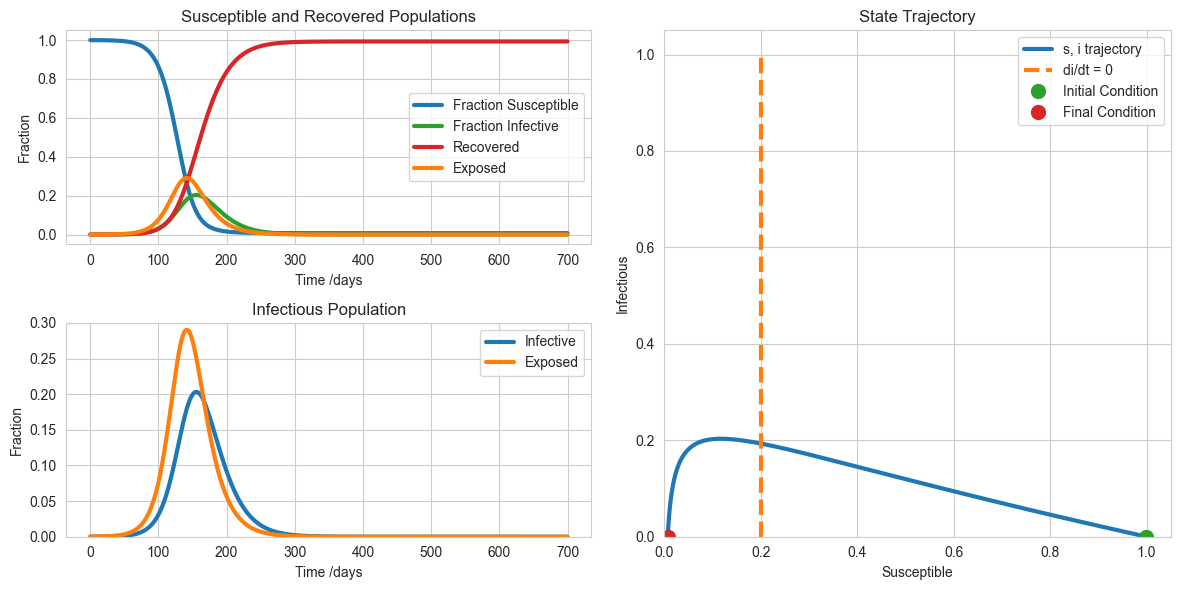

In [16]:
# parameter values
R0 = 5
t_incubation = 21

# initial number of infected and recovered individuals
e_initial = 10/40000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 0.05882
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 700, 700)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T

plotdata_SEIR(t, s, e, i, r)

## Let's build it on a network

generating graph G with 40000 nodes
doing Gillespie simulation
done with simulation, now plotting


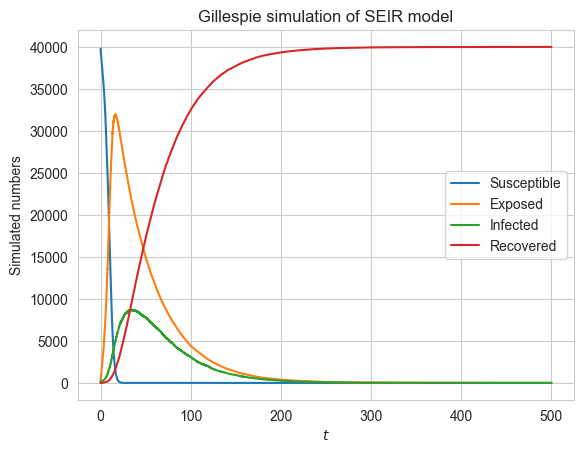

In [17]:
import EoN
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import random


N = 40000
print("generating graph G with {} nodes".format(N))
G_1 = nx.fast_gnp_random_graph(N, 50./(N-1))


#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5 for node in G_1.nodes()}
edge_attribute_dict = {edge: 0.5 for edge in G_1.edges()}
nx.set_node_attributes(G_1, values=node_attribute_dict,
name="expose2infect_weight")
nx.set_edge_attributes(G_1, values=edge_attribute_dict,
name="transmission_weight")


#
#These individual and partnership attributes will be used to scale
#the transition rates. When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.

#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node("S") #This line is actually unnecessary.
H.add_edge("E", "I", rate = 1/t_incubation, weight_label="expose2infect_weight")    #rate = alpha
H.add_edge("I", "R", rate = 0.05882)                                                #rate = gamma

J = nx.DiGraph() #for the induced transitions
J.add_edge(("I", "S"), ("I", "E"), rate = 5*0.05882, weight_label="transmission_weight") #rate = beta
IC = defaultdict(lambda: "S")
for node in range(200):
    IC[node] = "I"
    
    
return_statuses = ("S", "E", "I", "R")

print("doing Gillespie simulation")
t, S, E, I, R = EoN.Gillespie_simple_contagion(G_1, H, J, IC, return_statuses, tmax = float("Inf"))


print("done with simulation, now plotting")
plt.plot(t, S, label = "Susceptible")
plt.plot(t, E, label = "Exposed")
plt.plot(t, I, label = "Infected")
plt.plot(t, R, label = "Recovered")
plt.xlabel("$t$")
plt.ylabel("Simulated numbers")
plt.legend()
plt.title("Gillespie simulation of SEIR model")
plt.show()


# More complicated network

### LFR_benchmark_graph

Generation Completed


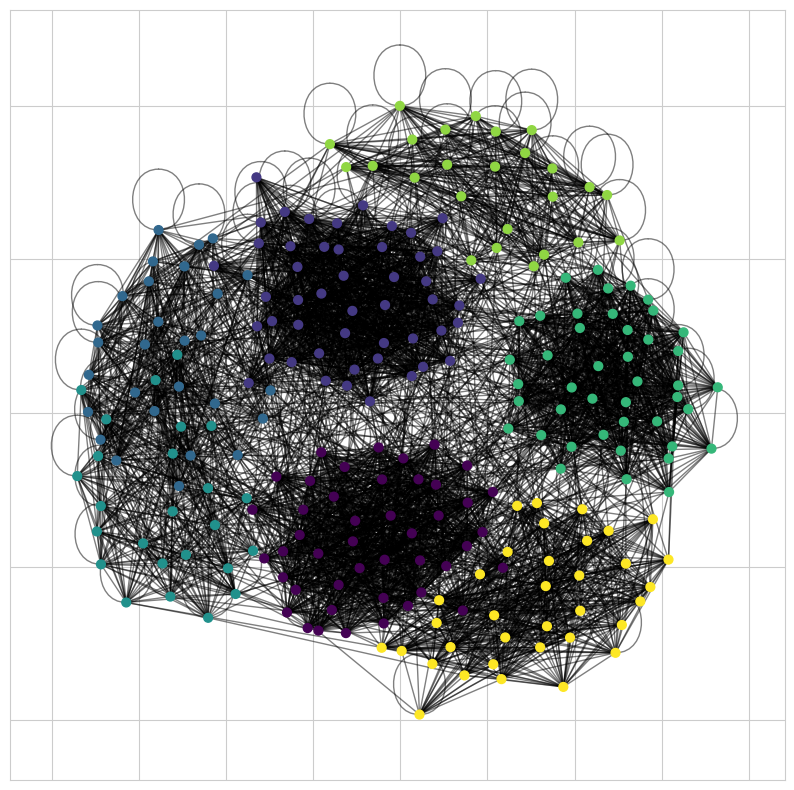

doing Gillespie simulation
59
done with simulation, now plotting


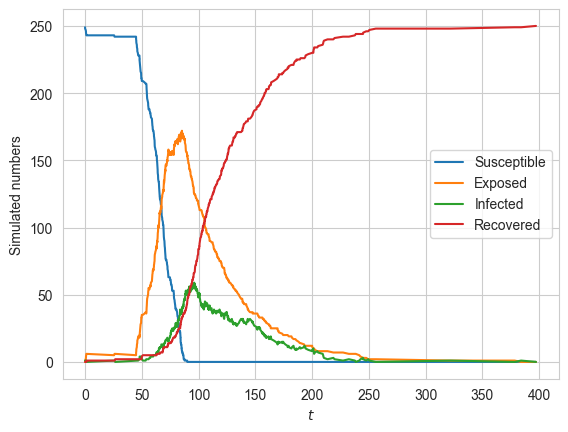

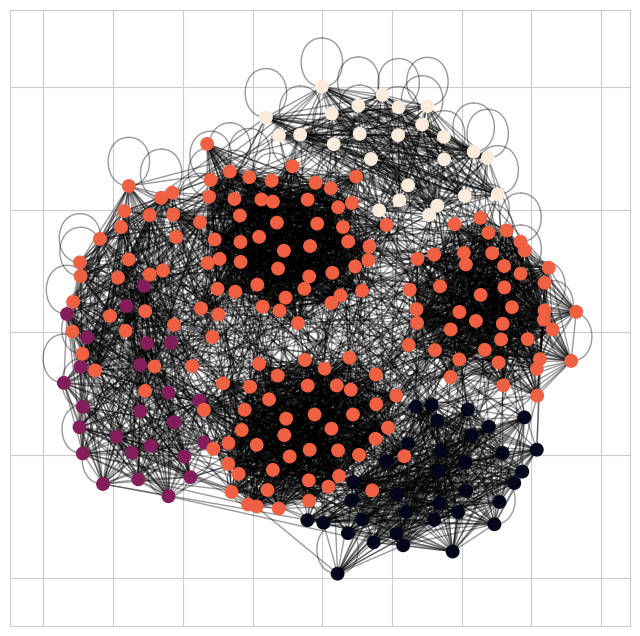

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


[[31  0  0 ...  0  0  0]
 [ 0 40  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 24  0 -1]
 [ 0  0  0 ...  0 36  0]
 [ 0  0  0 ... -1  0 20]]


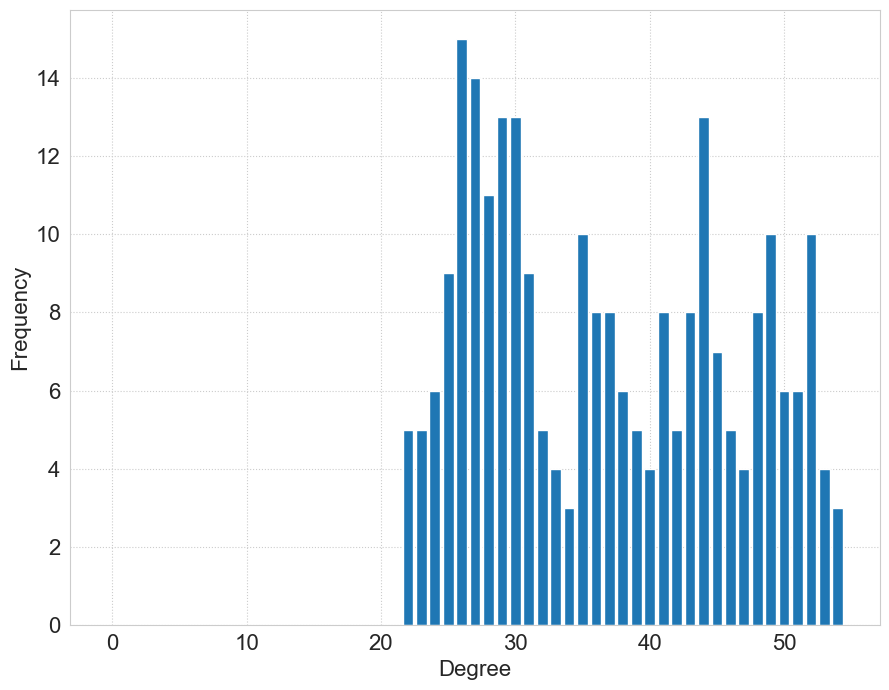

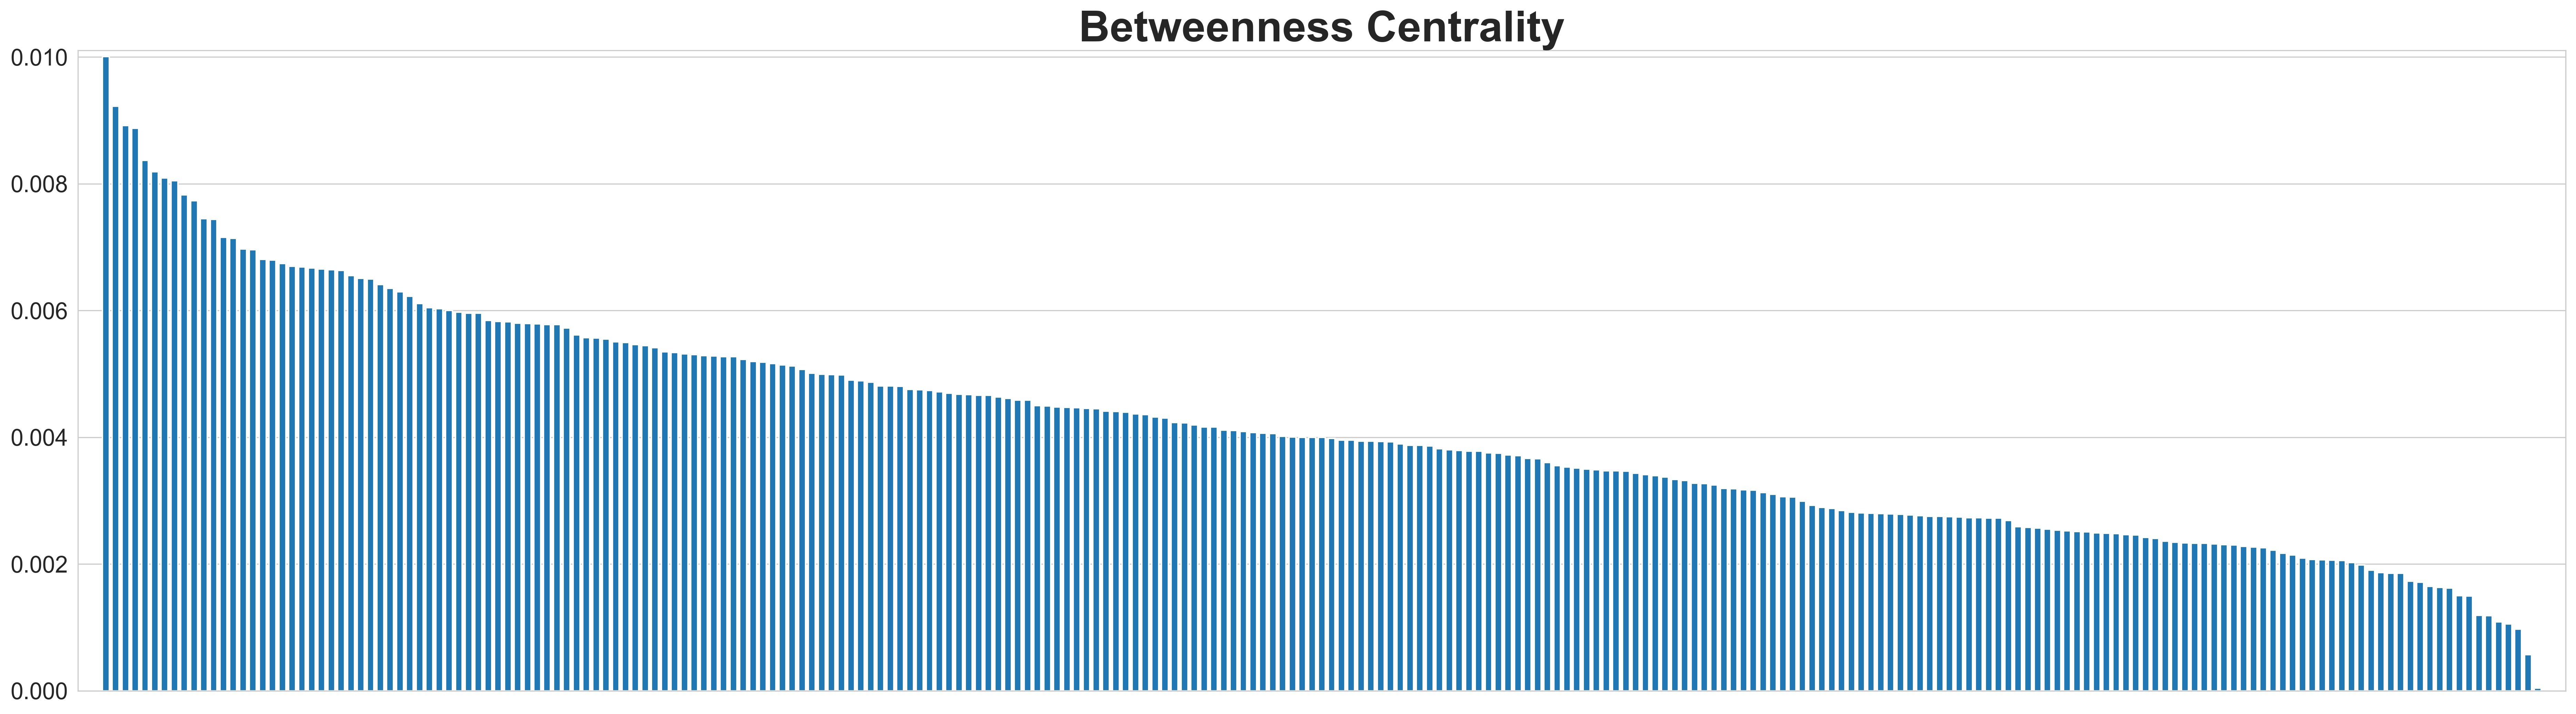

In [18]:
############################################### graph generation ###############################################

def genrate_lfr_graph(size=250):
    params = {"n":size, "tau1":1.1, "tau2":1.1, "mu":0.08, "min_degree":20, "max_degree":50}

    G = nx.LFR_benchmark_graph(params["n"], params["tau1"], params["tau2"], params["mu"], 
                        min_degree=params["min_degree"],
                        max_degree=params["max_degree"],
                        max_iters=5000, seed = 10,
                        )
    print("Generation Completed")
    return G  


sizes = [250, 500, 600, 700, 800, 900, 1000, 1200, 2000, 2500, 2800, 3000]
G = genrate_lfr_graph(size=250)

##################################### Community Detection ########################################
t_incubation = 21
partition = community_louvain.best_partition(G)
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(1,1,1)

#pos = nx.circular_layout(G)
pos= nx.kamada_kawai_layout(G)
# color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()),ax=ax)
nx.draw_networkx_edges(G, pos,alpha=0.5)
plt.savefig("./Images/lfr_lln_commun.png")
plt.show()


##################################### SIR modelization ########################################

G_1 = G
#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5 for node in G_1.nodes()}
edge_attribute_dict = {edge: 0.5 for edge in G_1.edges()}
nx.set_node_attributes(G_1, values=node_attribute_dict,
name="expose2infect_weight")
nx.set_edge_attributes(G_1, values=edge_attribute_dict,
name="transmission_weight")


#
#These individual and partnership attributes will be used to scale
#the transition rates. When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.

#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node("S") #This line is actually unnecessary.
H.add_edge("E", "I", rate = 1/t_incubation, weight_label="expose2infect_weight")    #rate = alpha
H.add_edge("I", "R", rate = 0.05882)                                                #rate = gamma

J = nx.DiGraph() #for the induced transitions
J.add_edge(("I", "S"), ("I", "E"), rate = 5*0.05882, weight_label="transmission_weight") #rate = beta
IC = defaultdict(lambda: "S")
for node in range(1):
    IC[node] = "I"
    
    
return_statuses = ("S", "E", "I", "R")

print("doing Gillespie simulation")
t, S, E, I, R = EoN.Gillespie_simple_contagion(G_1, H, J, IC, return_statuses, tmax = float("Inf"))
print(max(I))

print("done with simulation, now plotting")
plt.plot(t, S, label = "Susceptible")
plt.plot(t, E, label = "Exposed")
plt.plot(t, I, label = "Infected")
plt.plot(t, R, label = "Recovered")
plt.xlabel("$t$")
plt.ylabel("Simulated numbers")
plt.legend()
plt.savefig("./Images/SEIR_lft.png")
plt.show()


spectral_coords = nx.spectral_layout(G, dim=3)
partitions_kmeans = sklearn.cluster.KMeans(n_clusters=4).fit_predict([spectral_coords[node] for node in G.nodes()])
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(G, pos, node_color=partitions_kmeans, node_size=80)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()


# compute the Laplacian
L = nx.laplacian_matrix(G).todense()
print(L)

# Draw the communities in 2D with the Laplacian method
import plotly.graph_objs as go

# Plot of the 3-dimensional embedding of the nodes
spectral_coords = nx.spectral_layout(G, dim=3)
spectral_coords = list(zip(*spectral_coords.values()))

trace = go.Scatter3d(
    x=spectral_coords[0],
    y=spectral_coords[1],
    z=spectral_coords[2],
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
)

data = [trace]
camera = dict(eye=dict(x=1.5, y=1.5, z=0.1))

plot_figure = go.Figure(data=data, layout=layout)
plot_figure.update_layout(scene_camera=camera)

degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(9, 7))
plt.bar(degrees, degree_freq)
plt.grid(linestyle=':')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tight_layout()
plt.savefig("./Images/degree_histogram_LFR_graph.png")
plt.show()


between_centrality = nx.betweenness_centrality(G)
sorted_between_centrality =  sorted(between_centrality.items(), key=lambda x:x[1], reverse=True)
sorted_between_centrality = [(str(i), j) for i, j in sorted_between_centrality]

plt.figure(figsize=(25,7), dpi=300)
for i in range(1,len(sorted_between_centrality)):
    plt.bar(sorted_between_centrality[i][0], sorted_between_centrality[i][1],
            width=0.7, color ="tab:blue")
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.margins(0.01)
#hide the x axis
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
#title
plt.title('Betweenness Centrality', fontsize=30, fontweight='bold')
plt.tight_layout()
plt.savefig("./Images/betweenness_centrality_LFR_graph.png")
plt.show()

### random_cograph

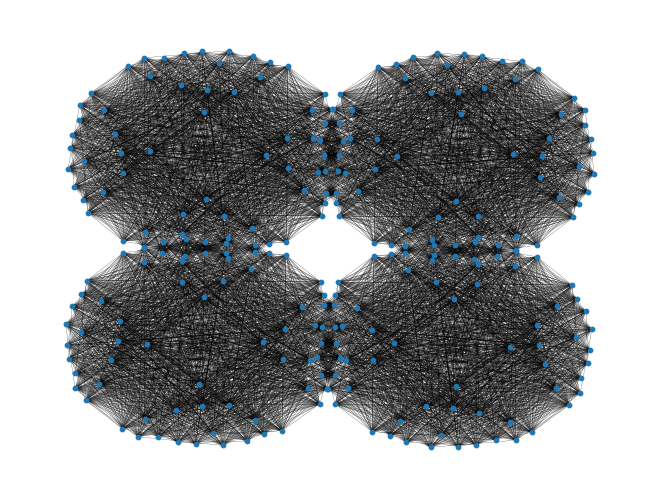

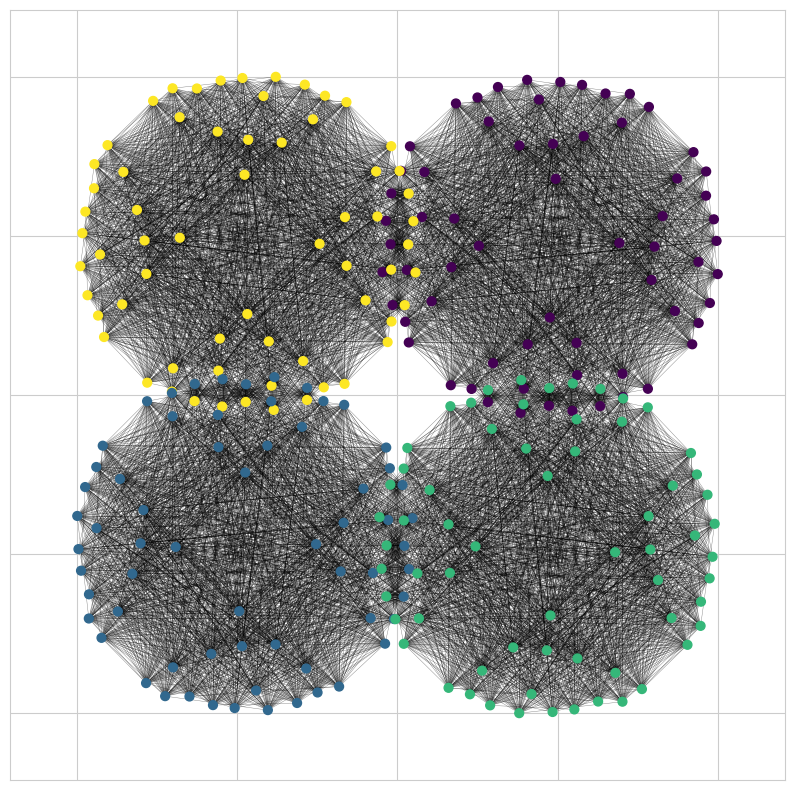

doing Gillespie simulation
done with simulation, now plotting


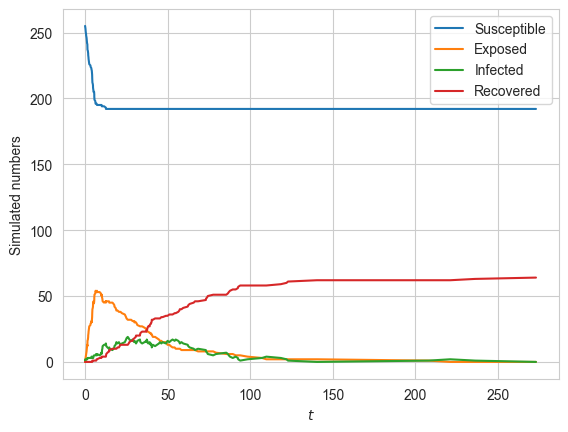

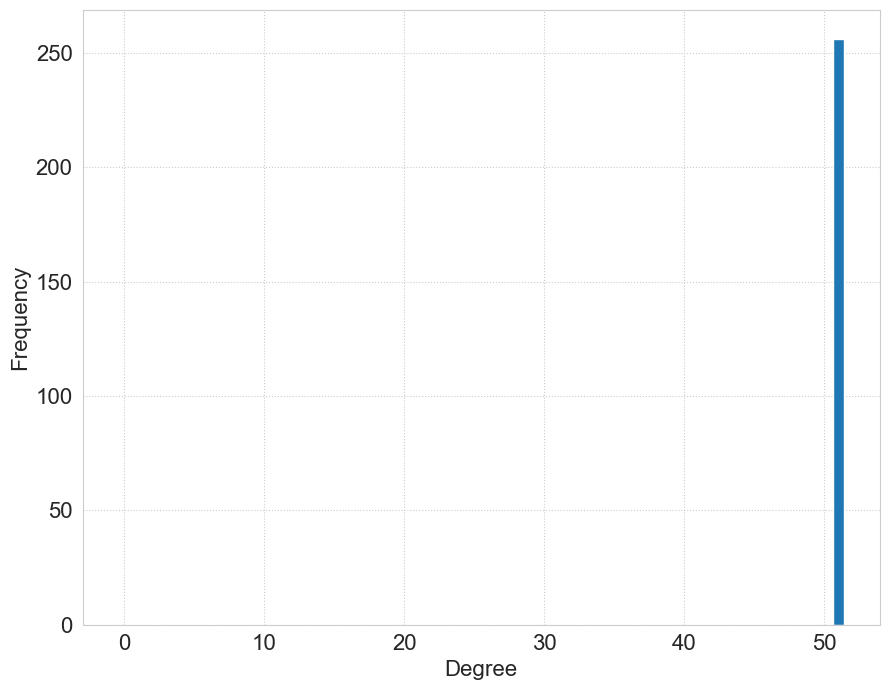

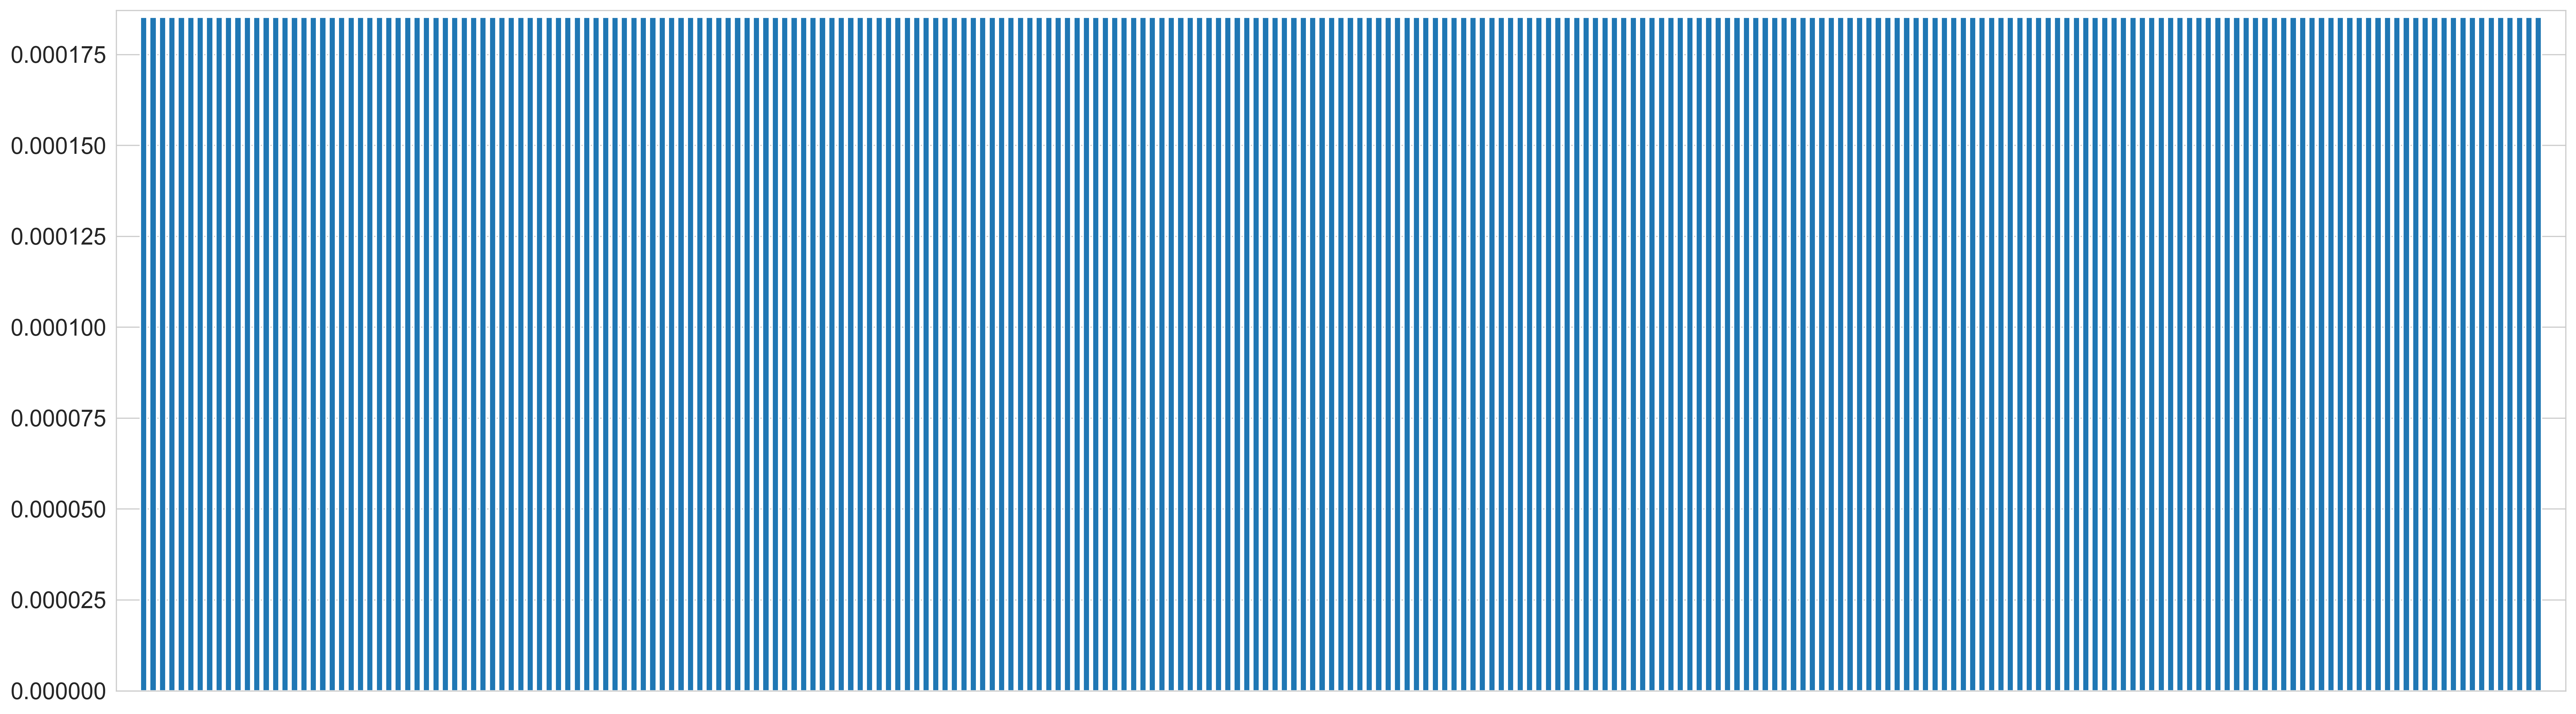

In [19]:
##################################### Graph création ########################################
G = nx.random_cograph(8, seed = 3)

pos= nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=False, node_size=10, pos=pos, width=0.15)
plt.show()    
len(G.edges())


##################################### Community Detection ########################################

partition = community_louvain.best_partition(G)
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(1,1,1)

#pos = nx.circular_layout(G)
pos= nx.kamada_kawai_layout(G)
# color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()),ax=ax)
nx.draw_networkx_edges(G, pos,alpha=0.5, width=0.3)
plt.savefig("./Images/random_cograph.png")
plt.show()


##################################### SIR modelization ########################################

G_1 = G
#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5 for node in G_1.nodes()}
edge_attribute_dict = {edge: 0.5 for edge in G_1.edges()}
nx.set_node_attributes(G_1, values=node_attribute_dict,
name="expose2infect_weight")
nx.set_edge_attributes(G_1, values=edge_attribute_dict,
name="transmission_weight")


#
#These individual and partnership attributes will be used to scale
#the transition rates. When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.

#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node("S") #This line is actually unnecessary.
H.add_edge("E", "I", rate = 1/t_incubation, weight_label="expose2infect_weight")    #rate = alpha
H.add_edge("I", "R", rate = 0.05882)                                                #rate = gamma

J = nx.DiGraph() #for the induced transitions
J.add_edge(("I", "S"), ("I", "E"), rate = 5*0.05882, weight_label="transmission_weight") #rate = beta
IC = defaultdict(lambda: "S")
for node in range(1):
    IC[node] = "I"
    
    
return_statuses = ("S", "E", "I", "R")

print("doing Gillespie simulation")
t, S, E, I, R = EoN.Gillespie_simple_contagion(G_1, H, J, IC, return_statuses, tmax = float("Inf"))


print("done with simulation, now plotting")
plt.plot(t, S, label = "Susceptible")
plt.plot(t, E, label = "Exposed")
plt.plot(t, I, label = "Infected")
plt.plot(t, R, label = "Recovered")
plt.xlabel("$t$")
plt.ylabel("Simulated numbers")
plt.legend()
plt.savefig("./Images/SEIR_random_cograph.png")
plt.show()


degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(9, 7))
plt.bar(degrees, degree_freq)
plt.grid(linestyle=':')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tight_layout()
plt.savefig("./Images/degree_histogram_random_cograph.png")
plt.show()


between_centrality = nx.betweenness_centrality(G)
sorted_between_centrality =  sorted(between_centrality.items(), key=lambda x:x[1], reverse=True)
sorted_between_centrality = [(str(i), j) for i, j in sorted_between_centrality]

plt.figure(figsize=(25,7), dpi=300)
for i in range(1,len(sorted_between_centrality)):
    plt.bar(sorted_between_centrality[i][0], sorted_between_centrality[i][1],
            width=0.7, color ="tab:blue")
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.margins(0.01)
#hide the x axis
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
#title
#plt.title('Betweenness Centrality', fontsize=30, fontweight='bold')
plt.tight_layout()
plt.savefig("./Images/betweenness_centrality_random_cograph.png")
plt.show()

# Cellular automate model

generating graph G
doing Gillespie simulation


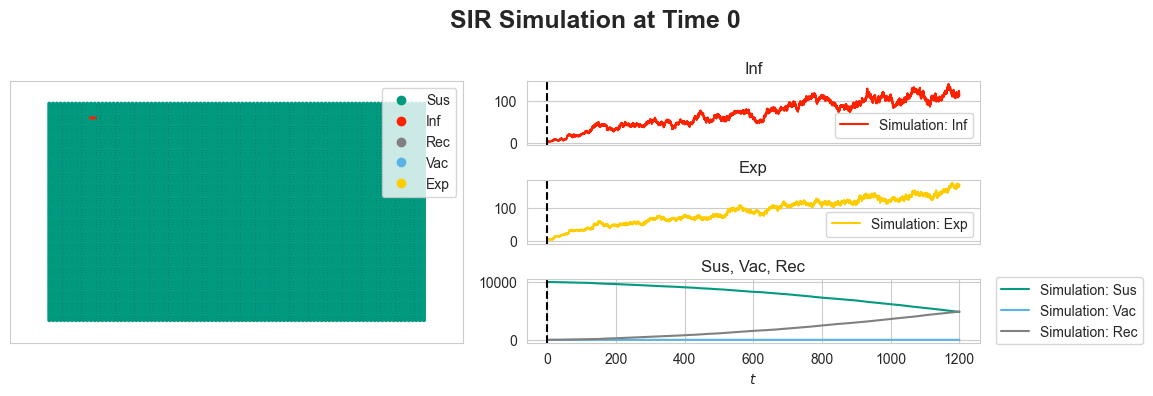

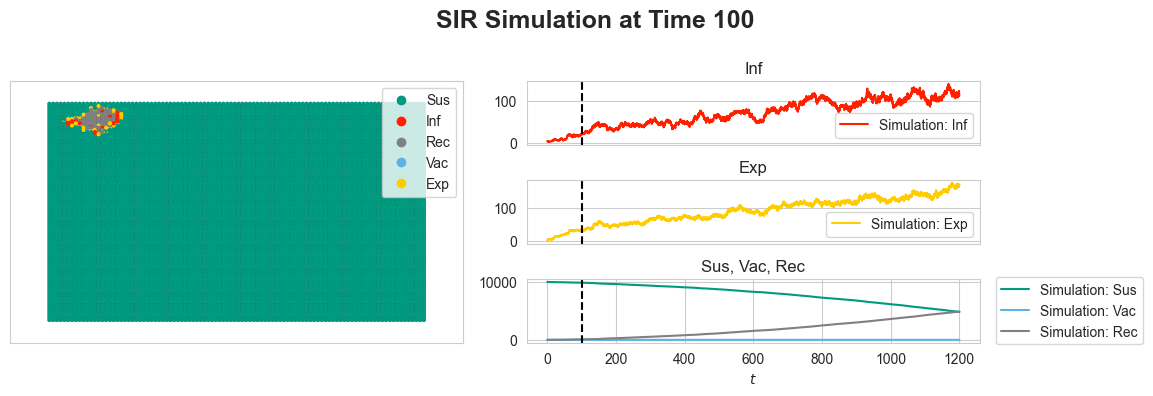

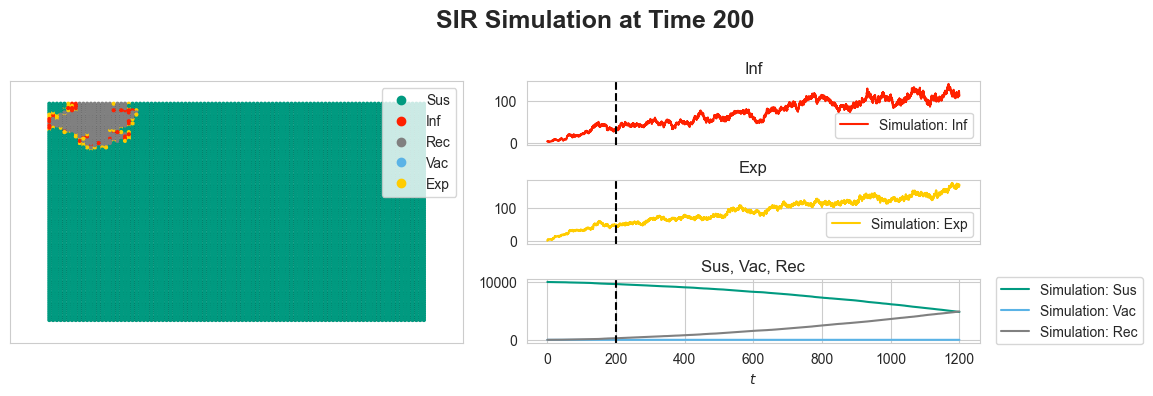

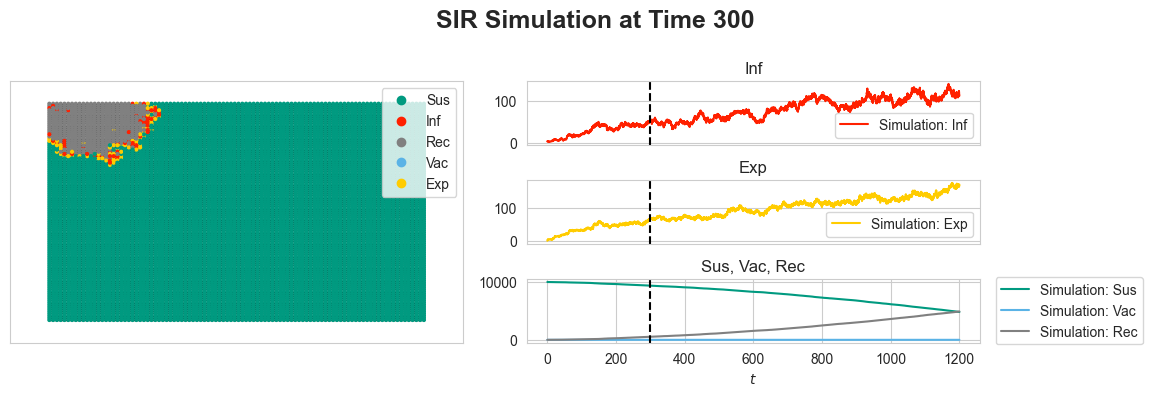

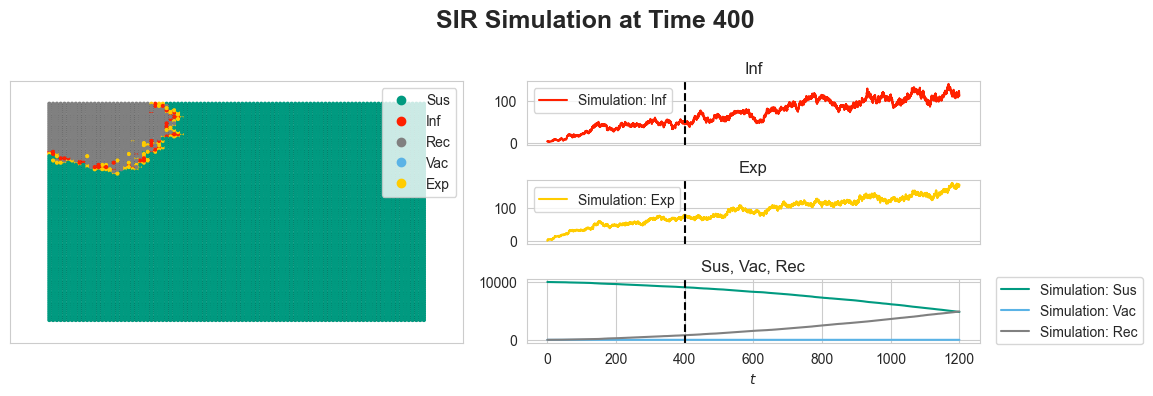

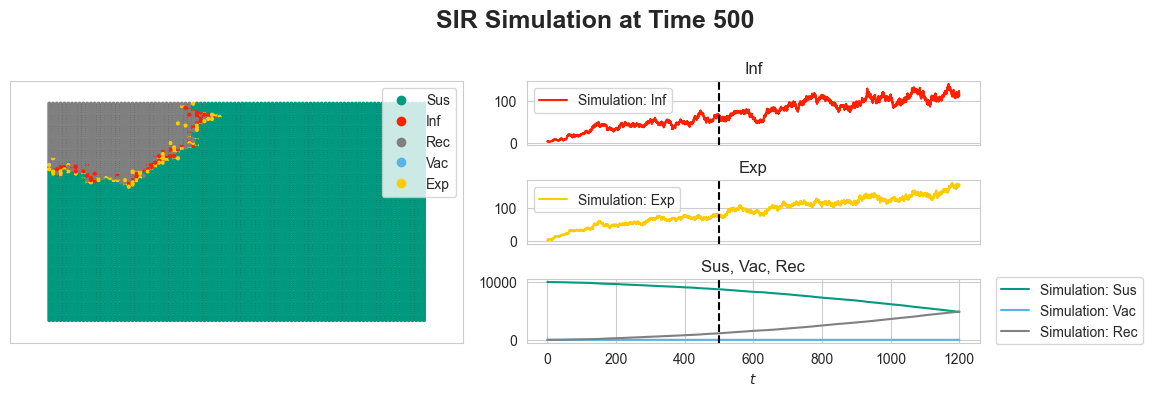

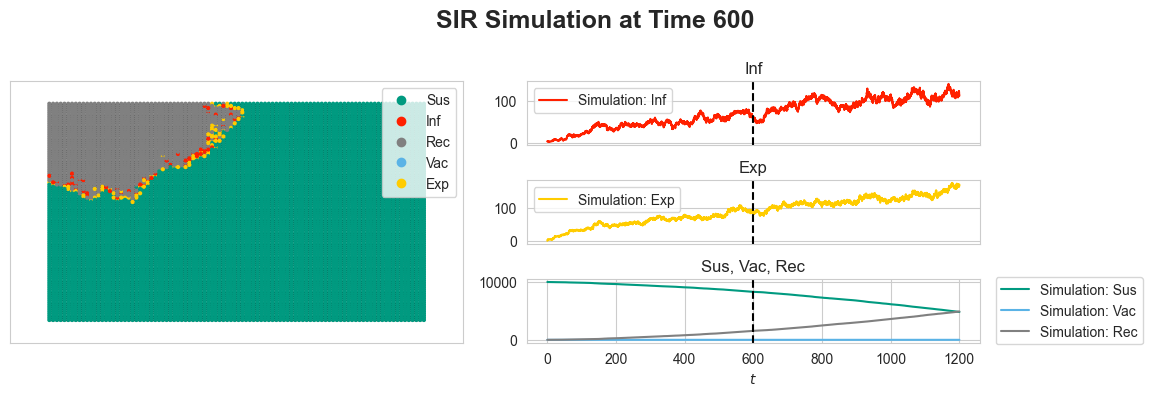

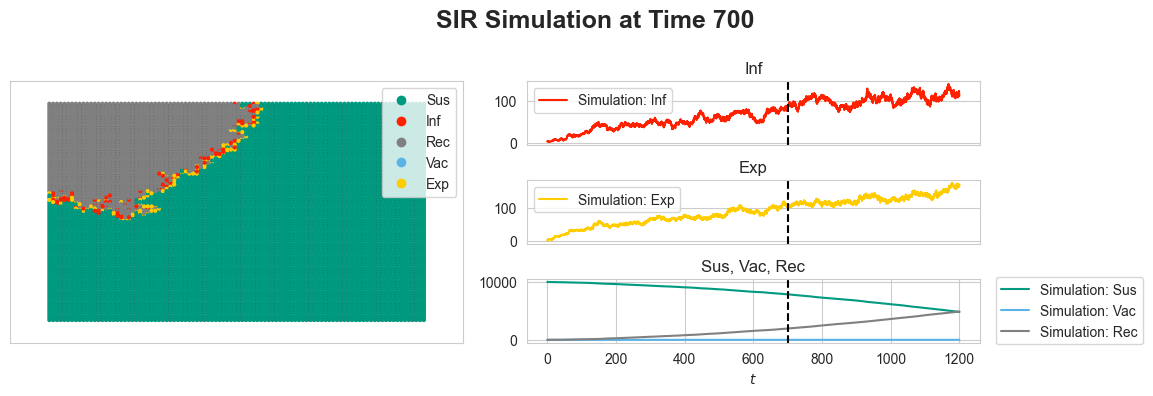

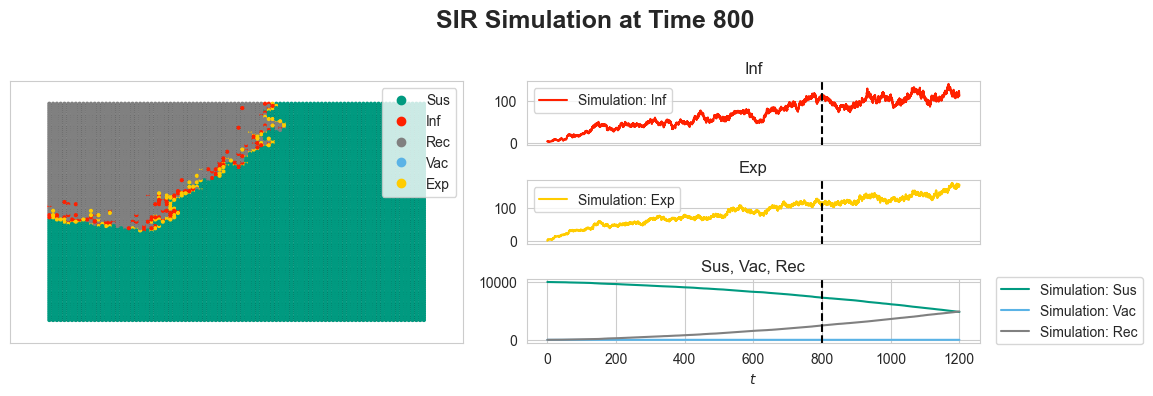

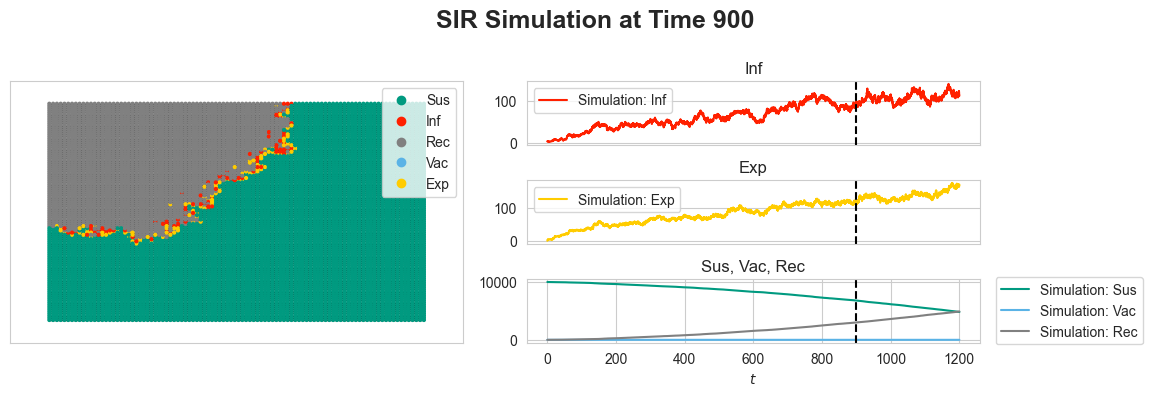

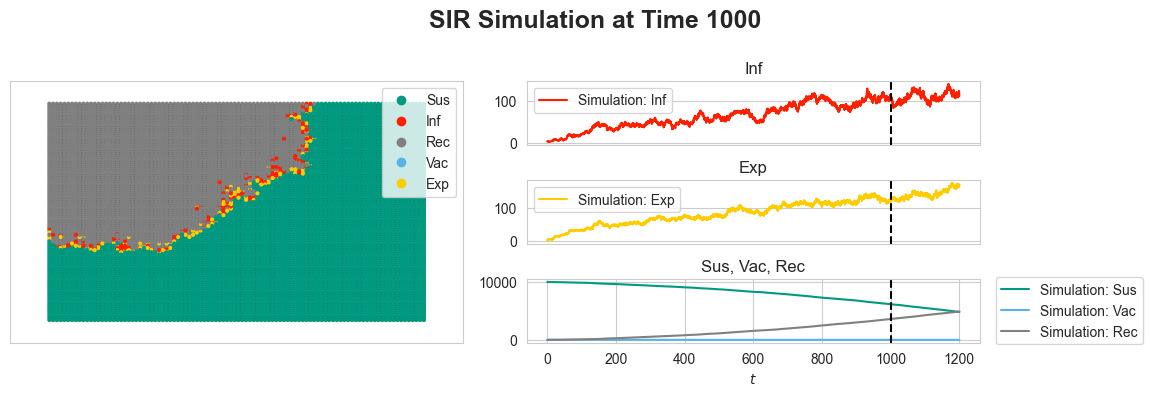

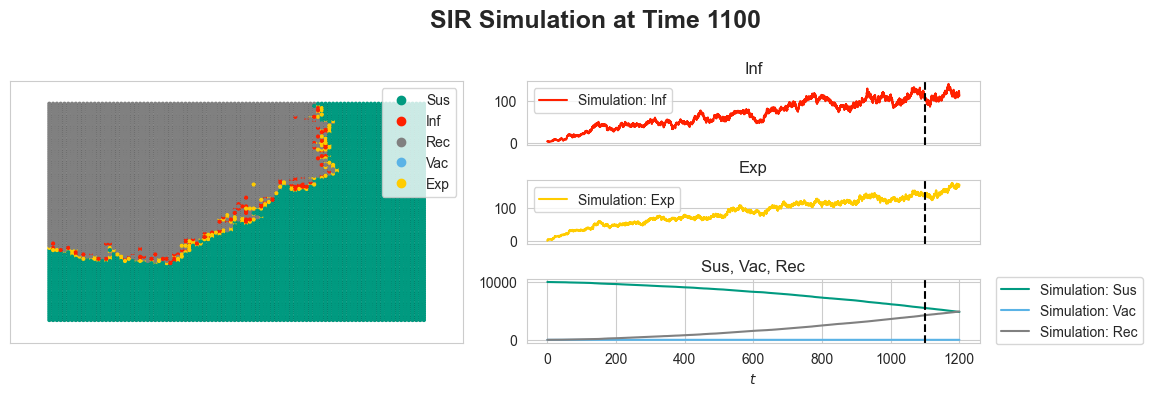

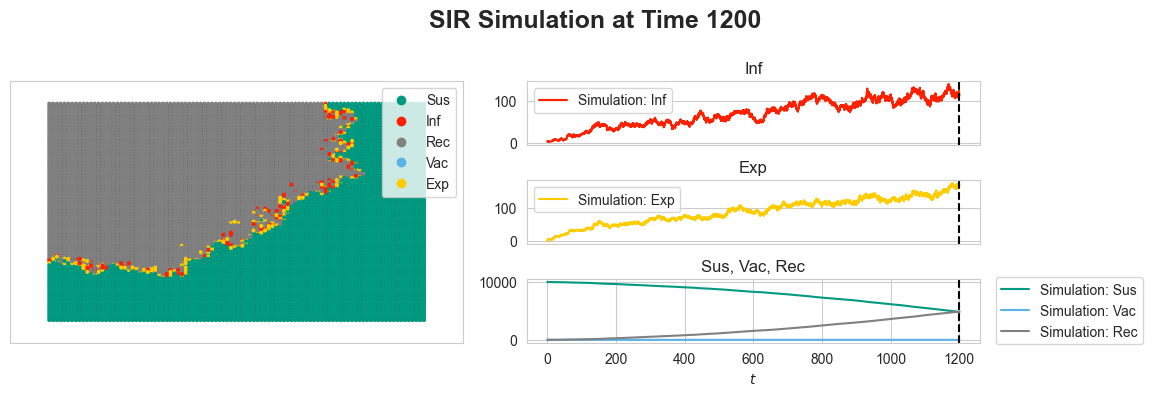

In [20]:
print("generating graph G")
G = nx.grid_2d_graph(100,100) #each node is (u,v) where 0<=u,v<=99
#we"ll initially infect those near the middle
initial_infections_group1 = [(u,v) for (u,v) in G if 10<u<13 and 91<v<94]
initial_infections_group2 = [(u,v) for (u,v) in G if 90<u<94 and 91<v<94]
initial_infections_group3 = [(u,v) for (u,v) in G if 45<u<55 and 5<v<9]
initial_infections = initial_infections_group1 

initial_vacinations = [(u,v) for (u,v) in G if 15<u<17 and  20<v<100]

H = nx.DiGraph() #the spontaneous transitions
H.add_edge("Sus", "Vac", rate = 0.000)  #normal vaccination rate = 0.001
H.add_edge("Exp", "Inf", rate = 1/t_incubation) #rate = alpha
H.add_edge("Inf", "Rec", rate = 0.05882)    #rate = gamma
J = nx.DiGraph() #the induced transitions
J.add_edge(("Inf", "Sus"), ("Inf", "Exp"), rate = 5*0.05882) #rate = beta

IC = defaultdict(lambda:"Sus") #a "dict", but by default the value is \texttt{"Sus"}.
for node in initial_infections:
    IC[node] = "Inf"

def init_vacinate():
    if "initial_vacinations" in globals():
        for node in initial_vacinations:
            IC[node] = "Vac"
            
#init_vacinate()

    
return_statuses = ["Sus", "Inf", "Rec", "Vac", "Exp"]

color_dict = {"Sus": "#009a80","Inf":"#ff2000", "Rec":"gray","Vac": "#5AB3E6", "Exp":"#ffcc00"}
pos = {node:node for node in G}
tex = False
sim_kwargs = {"color_dict":color_dict, "pos":pos, "tex":tex}
print("doing Gillespie simulation")
tmax = 1200
sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=tmax,
return_full_data=True, sim_kwargs=sim_kwargs)
times, D = sim.summary()
#
#times is a numpy array of times. D is a dict, whose keys are the entries in
#return_statuses. The values are numpy arrays giving the number in that
#status at the corresponding time.
newD = {"Sus+Vac":D["Sus"]+D["Vac"], "Inf+Rec" : D["Inf"] + D["Rec"]}
#
#newD is a new dict giving number not yet infected or the number ever infected
#Let"s add this timeseries to the simulation.
#
new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label = "Simulation",
color_dict={"Sus+Vac":"#E69A00", "Inf+Rec":"#CD9AB3"})
#ts_plots=[["Inf"], ["Exp"],["Sus" "Rec", "Vac"]]
ts_plots=[["Inf"], ["Exp"], ["Sus",  "Vac", "Rec"]]

for i in range(0,tmax+1, 100):
    sim.display(time=i, node_size = 4, ts_plots=ts_plots)
    plt.suptitle('SIR Simulation at Time {}'.format(i), fontweight='bold', fontsize=18, x=0.6)
    plt.subplots_adjust(top=0.8)
    plt.legend(bbox_to_anchor=(1.36, 0.5), loc='center right', borderaxespad=0.)
    #savefig in Images folder
    #plt.savefig('Images/SIR_{}.png'.format(i),  bbox_inches='tight')
    plt.show()
    
